In [93]:
import numpy as np
import cv2
import os
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Activation, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import seaborn as sn
import matplotlib.pyplot as plt
from collections import Counter
import random
import pandas as pd
!pip install imutils
import imutils
from imutils.contours import sort_contours
from tensorflow.keras.utils import plot_model


In [94]:

# Initializing lists to store image data  labels
images = []
image_labels = []

# Path to the dataset directory
dataset_path = '/kaggle/input/datasetmy/data/dataset'

for label_name in os.listdir(dataset_path):
    label_folder_path = os.path.join(dataset_path, label_name)
    
    if os.path.isdir(label_folder_path):
        for image_filename in os.listdir(label_folder_path):
            image_file_path = os.path.join(label_folder_path, image_filename)
            
            image = cv2.imread(image_file_path)
            if image is not None:
                images.append(image)
                image_labels.append(label_name)
            else:
                print(f"Warning: Failed to load image at {image_file_path}")

# Printing 
print(f"Total images: {len(images)}")
print(f"Total labels: {len(image_labels)}")

unique_image_labels = set(image_labels)
print(f"Labels: {list(unique_image_labels)}")


Total images: 7598
Total labels: 7598
Labels: ['9', '6', '0', '4', '8', '5', '2', 'div', 'sub', 'mul', '7', '1', '3', 'add']


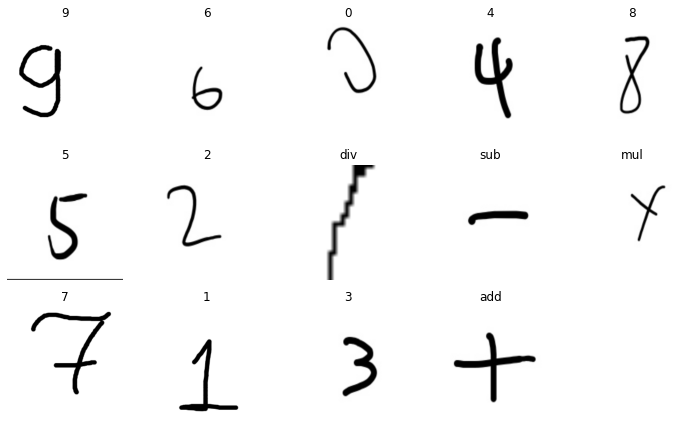

In [95]:
#Plotting to see numbers and symbols in dataset
fig = plt.figure(figsize=(10, 10))

unique_labels = list(set(image_labels))

for j, label in enumerate(unique_labels):
    idx = image_labels.index(label)
    img = images[idx]
    img = cv2.resize(img, (256, 256))
    
    fig.add_subplot(5, 5, j + 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(label)

plt.tight_layout()
plt.show()


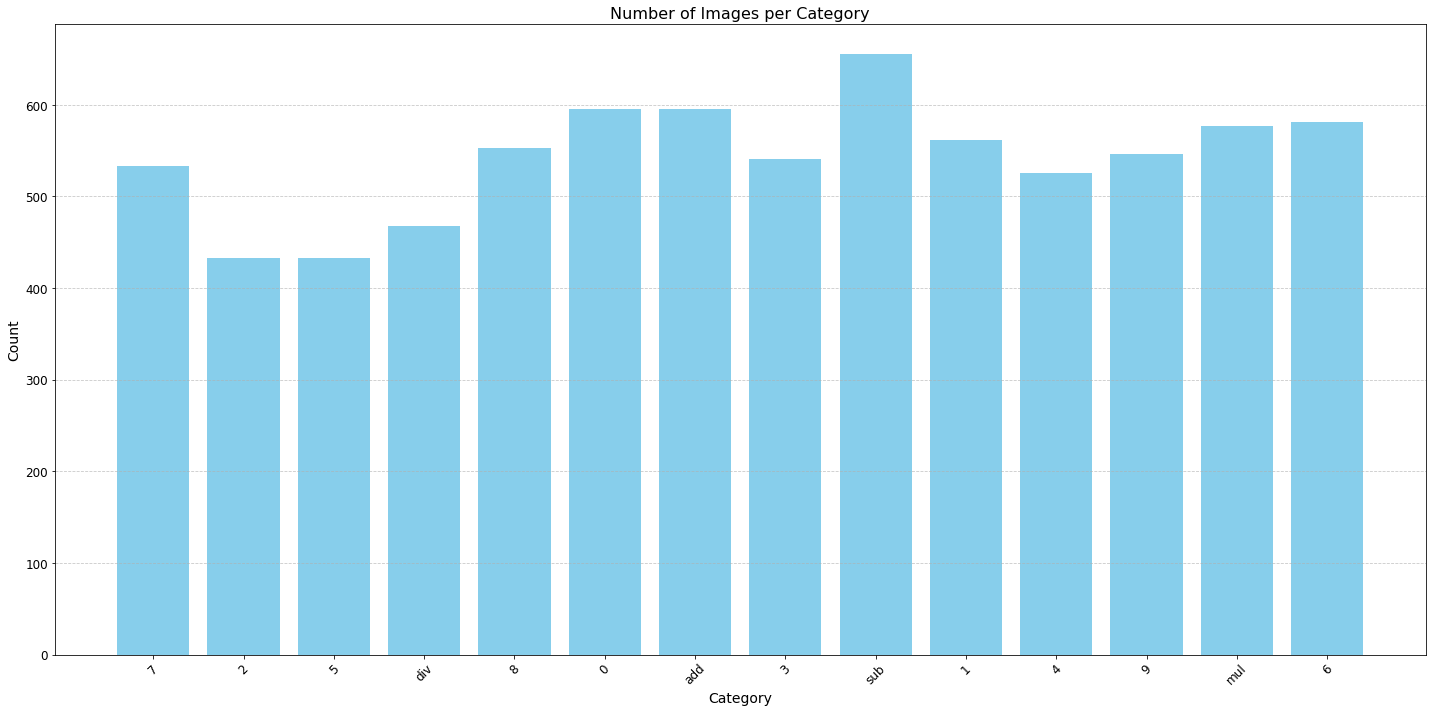

In [96]:
#Plotting to data distribution for each number and symbol

label_counts = Counter(image_labels)

unique_labels = list(label_counts.keys())
counts = list(label_counts.values())

plt.figure(figsize=(20, 10))
plt.bar(unique_labels, counts, color='skyblue')
plt.title('Number of Images per Category', fontsize=16)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [97]:
#Printing Unique labels and their lengths
unique_labels = list(set(image_labels)) 
print("Length of  unique labels: ", len(unique_labels), " : ", unique_labels)

Length of  unique labels:  14  :  ['9', '6', '0', '4', '8', '5', '2', 'div', 'sub', 'mul', '7', '1', '3', 'add']


In [98]:
#Printing the total number of images
processed_images = []
for i in range(len(images)):
    img = images[i]
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    threshold_image = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    threshold_image = cv2.resize(threshold_image, (32, 32))
    processed_images.append(threshold_image)
print(len(processed_images))


7598


In [99]:
#Printing the total number of labels in dataset
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(image_labels)
print(len(encoded_labels))


7598


In [100]:
#Splitting the data to train and test

X_train, X_test, y_train, y_test = train_test_split(processed_images, encoded_labels, test_size=0.2)  

print("Length of train_image : " , len(X_train) , " , length of labels list : " ,len(y_train))
print("Length of test_image : " , len(X_test) , " , length of labels list : " ,len(y_test))

Length of train_image :  6078  , length of labels list :  6078
Length of test_image :  1520  , length of labels list :  1520


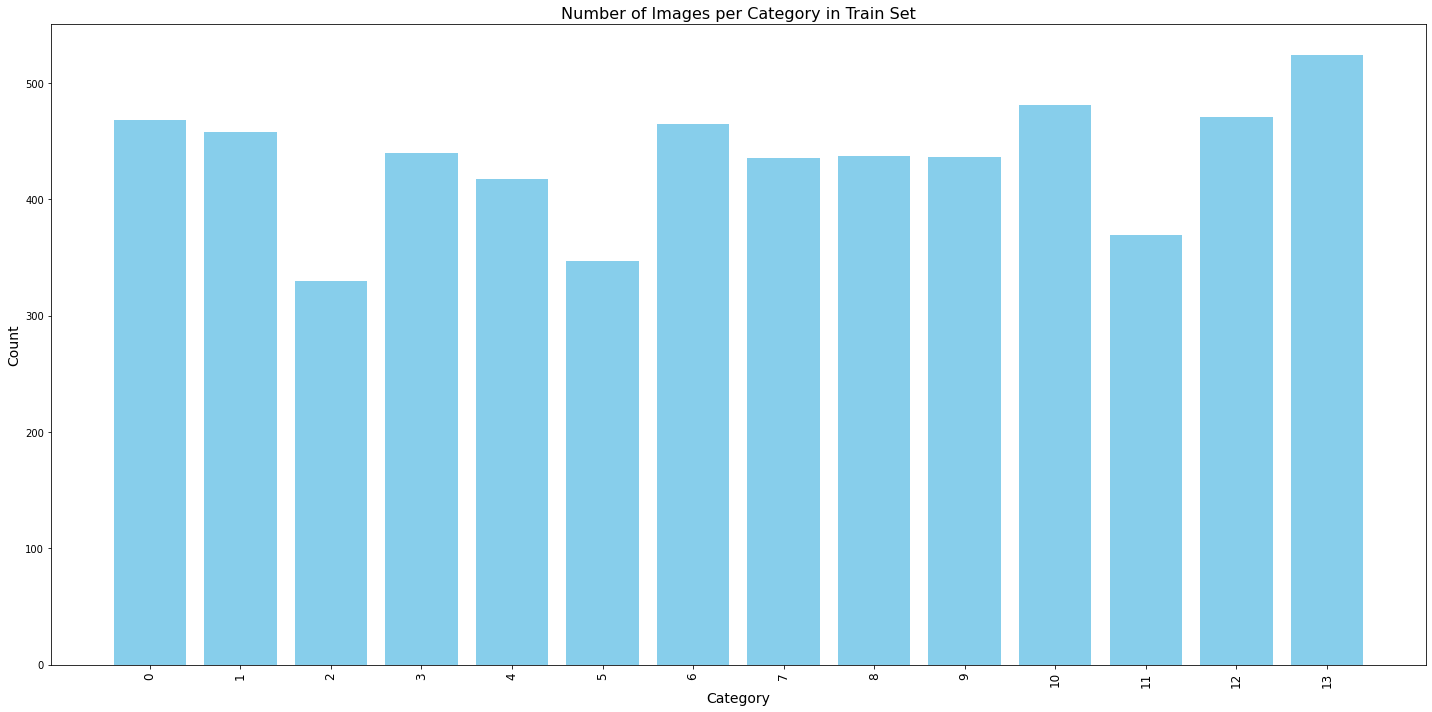

In [101]:
# Plot of data distribution of Train data

unique_train, count_train = np.unique(y_train, return_counts=True)

plt.figure(figsize=(20, 10))
plt.bar(unique_train, count_train, color='skyblue')
plt.title('Number of Images per Category in Train Set', fontsize=16)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(unique_train, rotation=90, fontsize=12)
plt.tight_layout()
plt.show()


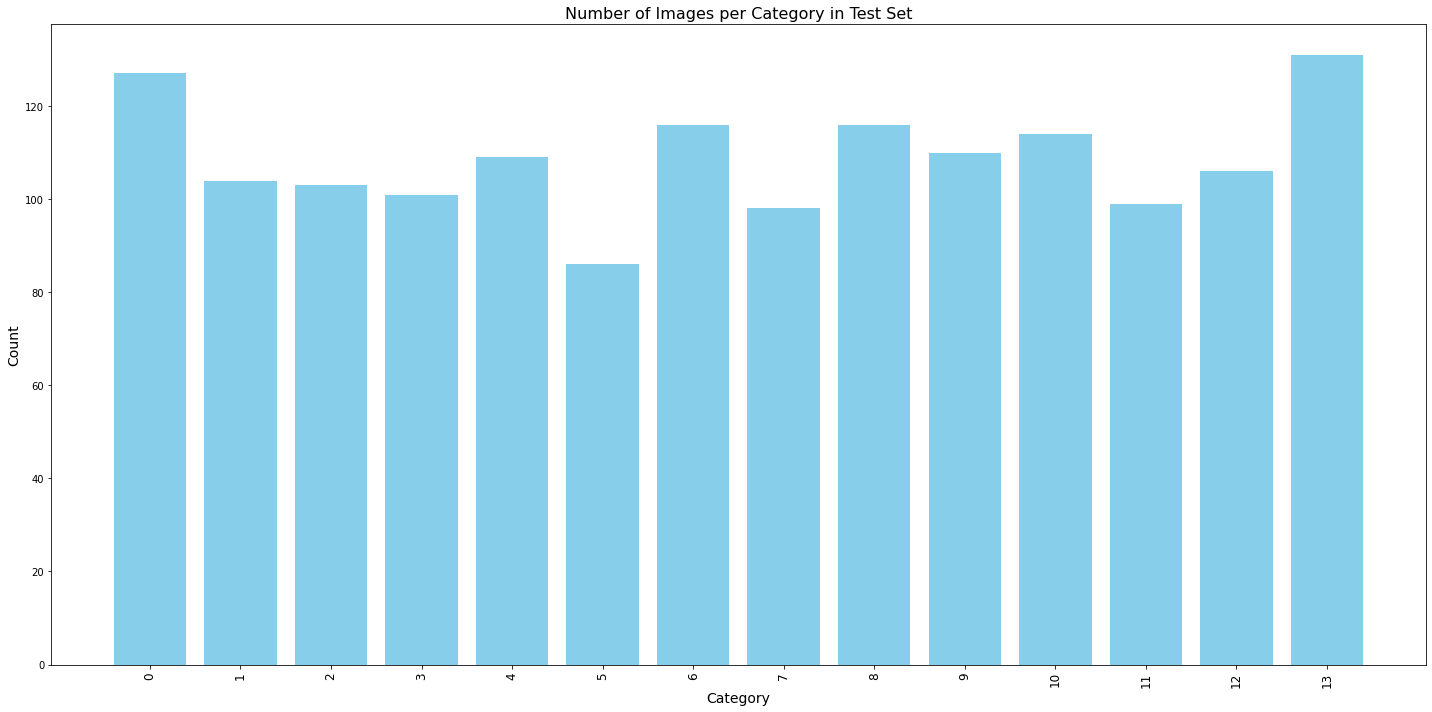

In [102]:
# Plot of data distribution of Test data

unique_test, count_test = np.unique(y_test, return_counts=True)

plt.figure(figsize=(20, 10))
plt.bar(unique_test, count_test, color='skyblue')
plt.title('Number of Images per Category in Test Set', fontsize=16)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(unique_test, rotation=90, fontsize=12)
plt.tight_layout()
plt.show()


In [103]:
# Class Distribution (Train Set and Test Set)
print(f"Train Set Class Distribution:\n{dict(zip(unique_train, count_train))}")
print(f"Test Set Class Distribution:\n{dict(zip(unique_test, count_test))}")



Train Set Class Distribution:
{0: 468, 1: 458, 2: 330, 3: 440, 4: 417, 5: 347, 6: 465, 7: 435, 8: 437, 9: 436, 10: 481, 11: 369, 12: 471, 13: 524}
Test Set Class Distribution:
{0: 127, 1: 104, 2: 103, 3: 101, 4: 109, 5: 86, 6: 116, 7: 98, 8: 116, 9: 110, 10: 114, 11: 99, 12: 106, 13: 131}


In [104]:
# Converting to NumPy arrays 
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

# one-hot encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Reshaping the data to add an extra dimension
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

# Normalizing pixel values 
X_train = X_train / 255.0
X_test = X_test / 255.0

# Printing
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (6078, 32, 32, 1)
X_test shape: (1520, 32, 32, 1)
y_train shape: (6078, 14)
y_test shape: (1520, 14)


In [105]:
def model_func(input_shape=(32, 32, 1)):

    # Regularization to prevent overfitting
    regularizer = l2(0.01)

    # Initializing the Sequential model
    model = Sequential()

    # Input layer and first convolutional layer
    model.add(Input(shape=input_shape))  # Specify the input shape of the images
    model.add(Conv2D(32, (3, 3), strides=(1, 1), padding='same',
                     kernel_initializer=glorot_uniform(seed=0),  # Xavier initialization for weights
                     name='conv1', activity_regularizer=regularizer))  # Regularizer to control overfitting
    model.add(Activation(activation='relu', name='Activation1'))  # ReLU activation for non-linearity
    model.add(MaxPool2D((2, 2), strides=(2, 2)))  # Downsample by reducing spatial dimensions by half

    # Second convolutional layer
    model.add(Conv2D(32, (3, 3), strides=(1, 1), padding='same',
                     kernel_initializer=glorot_uniform(seed=0),
                     name='conv2', activity_regularizer=regularizer))
    model.add(Activation(activation='relu', name='Activation2'))
    model.add(MaxPool2D((2, 2), strides=(2, 2)))  # Further downsampling

    # Third convolutional layer
    model.add(Conv2D(64, (3, 3), strides=(1, 1), padding='same',
                     kernel_initializer=glorot_uniform(seed=0),
                     name='conv3', activity_regularizer=regularizer))
    model.add(Activation(activation='relu', name='Activation3'))
    model.add(MaxPool2D((2, 2), strides=(2, 2)))  # Downsample again to extract features

    # Flatten the output from 2D feature maps into 1D
    model.add(Flatten())

    # Add dropout to reduce overfitting by randomly turning off neurons during training
    model.add(Dropout(0.5))

    # Fully connected layers for classification
    model.add(Dense(120, activation='relu', kernel_initializer=glorot_uniform(seed=0), name='fc1'))  # First dense layer
    model.add(Dense(84, activation='relu', kernel_initializer=glorot_uniform(seed=0), name='fc2'))   # Second dense layer
    model.add(Dense(14, activation='softmax', kernel_initializer=glorot_uniform(seed=0), name='fc3'))  # Output layer with 14 classes (softmax for probabilities)

    # Compile the model
    optimizer = Adam()  # Adam optimizer for adaptive learning rate
    model.compile(loss='categorical_crossentropy',  # Loss function for multi-class classification
                  optimizer=optimizer,             # Optimizer to minimize the loss
                  metrics=['accuracy'])            # Evaluation metric

    return model


In [106]:
model = model_func(input_shape=(32, 32, 1))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 32, 32, 32)        320       
_________________________________________________________________
Activation1 (Activation)     (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 16, 16, 32)        9248      
_________________________________________________________________
Activation2 (Activation)     (None, 16, 16, 32)        0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 8, 8, 32)          0         
_________________________________________________________________
conv3 (Conv2D)               (None, 8, 8, 64)         

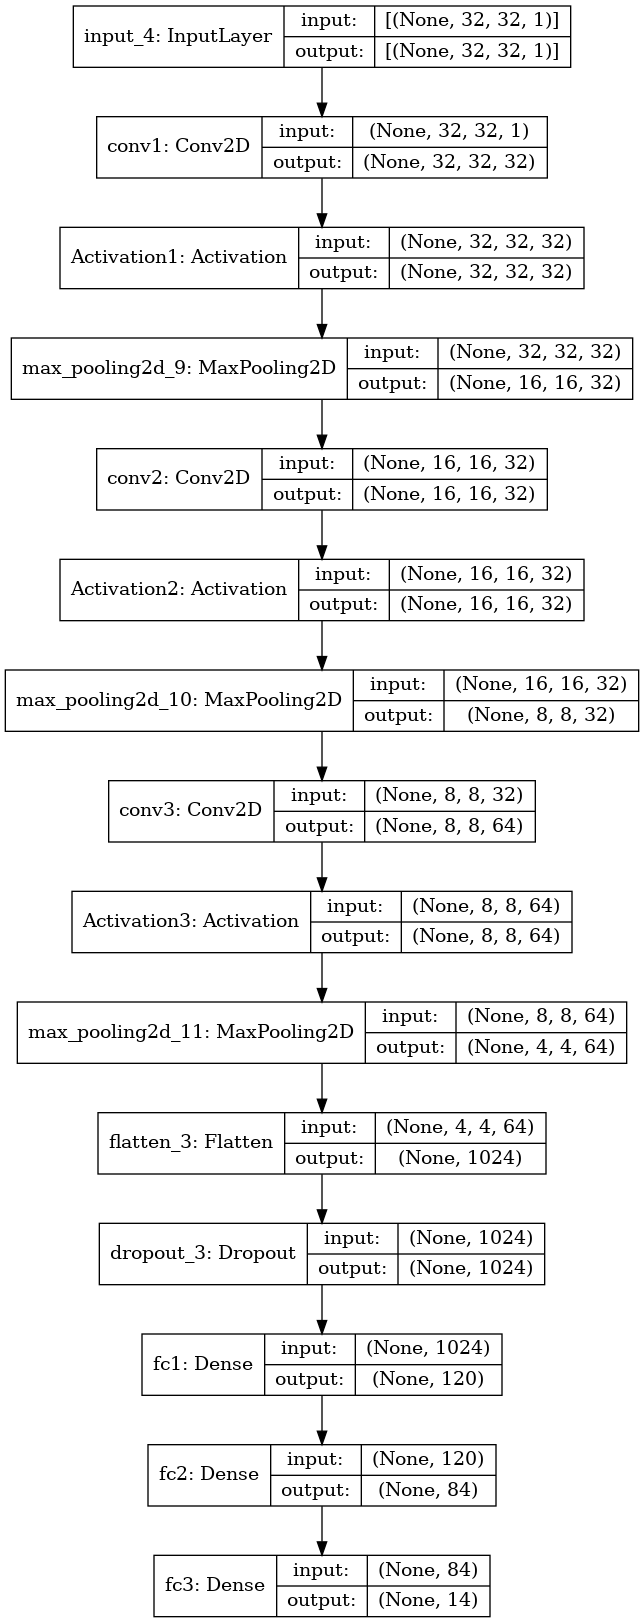

In [107]:
# plotting and showing the model
plot_model(model, "model.png", show_shapes=True)

In [108]:
# Step Decay function for learning rate adjustment
def step_decay(epoch):
    initial_learning_rate = 0.001
    dropEvery = 10
    factor = 0.5
    lr = initial_learning_rate * (factor ** np.floor((1 + epoch) / dropEvery))
    return float(lr)

# For saving the best model based on validation loss
checkpoint = ModelCheckpoint('math_symbol_and_digits_recognition.h5', 
                             monitor='val_loss', save_best_only=True, 
                             verbose=1, mode='min')

# For adjusting learning rate using step_decay
callbacks = [checkpoint, LearningRateScheduler(step_decay)]



In [109]:
## Defining the data augmentation
aug = ImageDataGenerator(zoom_range=0.1,
                         width_shift_range=0.05,
                         height_shift_range=0.05)

# Training the model with augmented data

hist = model.fit(
    aug.flow(X_train, y_train, batch_size=128), 
    batch_size=128, 
    epochs=48,
    validation_data=(X_test, y_test),
    callbacks = callbacks)


Epoch 1/48
48/48 [==============================] - 5s 89ms/step - loss: 2.7561 - accuracy: 0.2430 - val_loss: 2.2437 - val_accuracy: 0.4243

Epoch 00001: val_loss improved from inf to 2.24365, saving model to math_symbol_and_digits_recognition.h5
Epoch 2/48
48/48 [==============================] - 5s 96ms/step - loss: 1.7624 - accuracy: 0.5352 - val_loss: 1.5217 - val_accuracy: 0.6625

Epoch 00002: val_loss improved from 2.24365 to 1.52166, saving model to math_symbol_and_digits_recognition.h5
Epoch 3/48
48/48 [==============================] - 4s 87ms/step - loss: 1.2259 - accuracy: 0.6971 - val_loss: 1.1773 - val_accuracy: 0.7375

Epoch 00003: val_loss improved from 1.52166 to 1.17727, saving model to math_symbol_and_digits_recognition.h5
Epoch 4/48
48/48 [==============================] - 4s 83ms/step - loss: 0.9859 - accuracy: 0.7628 - val_loss: 1.2675 - val_accuracy: 0.7007

Epoch 00004: val_loss did not improve from 1.17727
Epoch 5/48
48/48 [==============================] - 4s 

In [110]:
# Loading the best model after training
model = load_model('math_symbol_and_digits_recognition.h5')


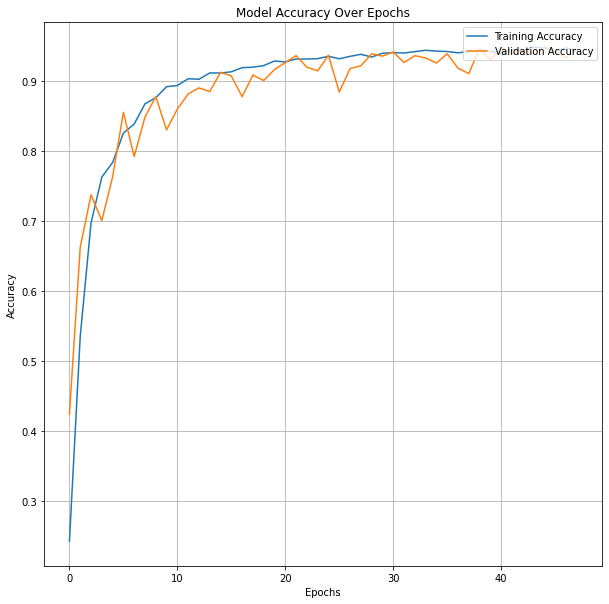

In [111]:
# Ploting Training Accuracy and validation Accuracy
figure = plt.figure(figsize=(10, 10))
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


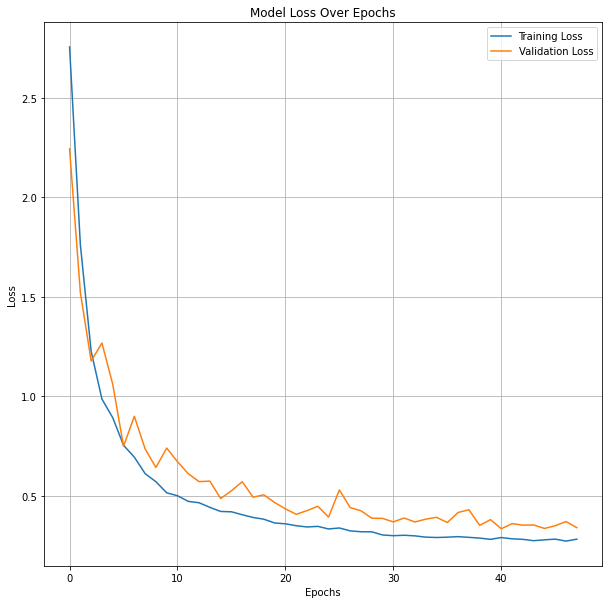

In [112]:
# Ploting Trainging Loss and Validation Loss
figure2 = plt.figure(figsize=(10, 10))
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

<Figure size 720x576 with 0 Axes>

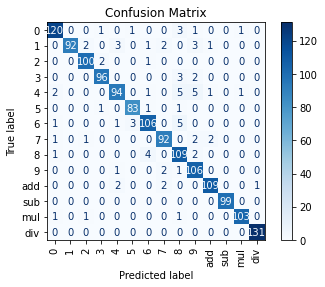

In [113]:

# Predicting the labels for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  
y_true_classes = np.argmax(y_test, axis=1)  

# Generating the confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# List of class labels 
class_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'add', 'sub', 'mul', 'div']

# confusion matrix
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical', values_format='d')
plt.title("Confusion Matrix")
plt.show()

In [114]:
# Predicting the labels for the test set
ypred = model.predict(X_test)

# Converting the predicted probabilities into class labels
ypred = np.argmax(ypred, axis=1)

# Converting the one-hot encoded true labels into class labels
Y_test_hat = np.argmax(y_test, axis=1)

# Printing classification report
print(classification_report(Y_test_hat, ypred))


              precision    recall  f1-score   support

           0       0.95      0.94      0.95       127
           1       1.00      0.88      0.94       104
           2       0.96      0.97      0.97       103
           3       0.96      0.95      0.96       101
           4       0.93      0.86      0.90       109
           5       0.95      0.97      0.96        86
           6       0.93      0.91      0.92       116
           7       0.94      0.94      0.94        98
           8       0.85      0.94      0.89       116
           9       0.88      0.96      0.92       110
          10       0.96      0.96      0.96       114
          11       1.00      1.00      1.00        99
          12       0.98      0.97      0.98       106
          13       0.99      1.00      1.00       131

    accuracy                           0.95      1520
   macro avg       0.95      0.95      0.95      1520
weighted avg       0.95      0.95      0.95      1520



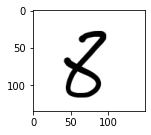

Predicted class: 8


In [120]:
# Getting test image and making  prediction
image = cv2.imread(r'/kaggle/input/datasetmy/data/dataset/8/10661.jpg', cv2.IMREAD_GRAYSCALE)

# Displaying image
plt.figure(figsize=(2, 2))
plt.imshow(image, cmap='gray')
plt.show()

# Preprocessing image
image = cv2.resize(image, (32, 32))
arrim = np.array(image)
arrim = np.expand_dims(arrim, axis=-1)
arrim = arrim/255.
arrim = np.array([np.array(arrim)])

# Making prediction
prediction = model.predict(arrim)
print(f"Predicted class: {np.argmax(prediction)}")

In [116]:
def detect_number(image_path):
    img = cv2.imread(image_path)
    
    # Resizing 
    img = cv2.resize(img, (800, 800))
    
    # Converting to  grayscale 
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Using Canny edge detection 
    edged = cv2.Canny(img_gray, 30, 150)
    contours = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    
    # Sorting the contours
    contours = sort_contours(contours, method="left-to-right")[0]
    
    # Defining the labels
    labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'add', 'div', 'mul', 'sub']
    
    for c in contours:
        (x, y, w, h) = cv2.boundingRect(c)
        
        if 20 <= w and 30 <= h:
            roi = img_gray[y:y+h, x:x+w]
            
            thresh = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
            
            (th, tw) = thresh.shape
            
            if tw > th:
                thresh = imutils.resize(thresh, width=32)
            if th > tw:
                thresh = imutils.resize(thresh, height=32)
            
            (th, tw) = thresh.shape
            
            dx = int(max(0, 32 - tw) / 2.0)
            dy = int(max(0, 32 - th) / 2.0)
            
            padded = cv2.copyMakeBorder(thresh, top=dy, bottom=dy, left=dx, right=dx, borderType=cv2.BORDER_CONSTANT, value=(0, 0, 0))
            
            padded = cv2.resize(padded, (32, 32))
            
            padded = np.array(padded)
            padded = padded / 255.  
            padded = np.expand_dims(padded, axis=0)  
            padded = np.expand_dims(padded, axis=-1)  
            
            pred = model.predict(padded)
            
            pred = np.argmax(pred, axis=1)
            label = labels[pred[0]]
            
            cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 255), 2)
            
            cv2.putText(img, label, (x-5, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255))

    # Display the result image with the detected symbols and labels
    figure = plt.figure(figsize=(10, 10))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
    plt.imshow(img)
    plt.axis('off')  
    plt.show()

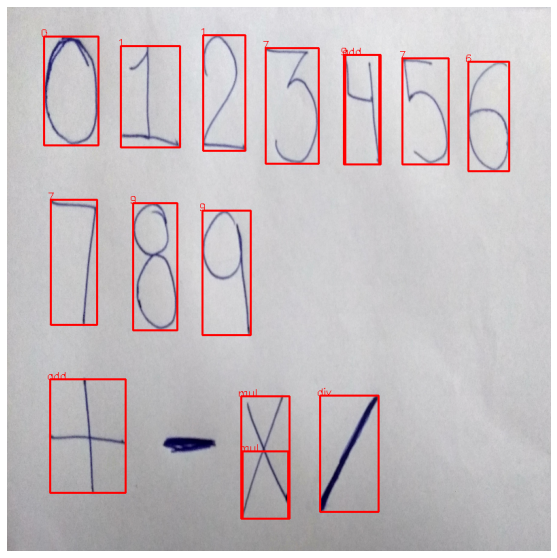

In [117]:
#Giving an image to see if it can detect numbers and symbols
test_pipeline('/kaggle/input/datasetmy/data/test.jpg')

In [118]:
def equation_solver(image_path):
    recognized_symbols = []
    image = cv2.imread(image_path)
    image_resized = cv2.resize(image, (800, 800))
    gray_image = cv2.cvtColor(image_resized, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray_image, 30, 150)
    contours_found = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours_found)
    sorted_contours = sort_contours(contours, method="left-to-right")[0]
    symbol_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'add', 'div', 'mul', 'sub']

    for contour in sorted_contours:
        x, y, width, height = cv2.boundingRect(contour)
        if 20 <= width and 30 <= height:
            roi = gray_image[y:y+height, x:x+width]
            binary_roi = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
            roi_height, roi_width = binary_roi.shape
            if roi_width > roi_height:
                binary_roi = imutils.resize(binary_roi, width=32)
            elif roi_height > roi_width:
                binary_roi = imutils.resize(binary_roi, height=32)
            pad_x = max(0, 32 - roi_width) // 2
            pad_y = max(0, 32 - roi_height) // 2
            padded_image = cv2.copyMakeBorder(binary_roi, top=pad_y, bottom=pad_y, left=pad_x, right=pad_x, 
                                              borderType=cv2.BORDER_CONSTANT, value=(0, 0, 0))
            padded_image = cv2.resize(padded_image, (32, 32))
            padded_image = np.array(padded_image) / 255.
            padded_image = np.expand_dims(padded_image, axis=0)
            padded_image = np.expand_dims(padded_image, axis=-1)
            prediction = model.predict(padded_image)
            predicted_class = np.argmax(prediction, axis=1)
            predicted_label = symbol_labels[predicted_class[0]]
            recognized_symbols.append(predicted_label)
            cv2.rectangle(image_resized, (x, y), (x+width, y+height), (0, 0, 255), 2)
            cv2.putText(image_resized, predicted_label, (x-5, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255))

    fig = plt.figure(figsize=(10, 10))
    image_rgb = cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()

    # Mapping symbols to their respective operators
    symbol_map = {'add': '+', 'sub': '-', 'mul': '*', 'div': '/'}
    expression = ''.join([symbol_map.get(symbol, symbol) for symbol in recognized_symbols])
    
    # Evaluating the expression
    try:
        result = eval(expression)
        print(f'Value of the equation {expression}: {result}')
    except Exception as e:
        print(f'Error evaluating the expression {expression}: {e}')


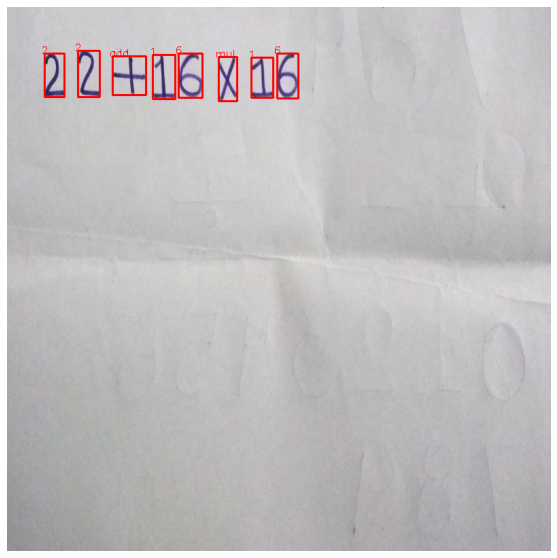

Value of the expression 22+16*16 : 278


In [119]:
# Now giving a handwritten equation and outputing solved equation
test_pipeline_equation('/kaggle/input/datasetmy/data/test_equation4.jpg')
